# Testing Fisher score for drift detection

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# re-create toy y = x ** 3 + eps example from https://arxiv.org/abs/1910.02600

torch.manual_seed(0)

x_train = torch.linspace(-5, 4, 2000).unsqueeze(-1)
# mask = (x_train < -4) | (x_train > -1)
# x_train = x_train[mask].unsqueeze(-1)

sigma = torch.distributions.Gamma(concentration=2,rate=0.5).sample(x_train.shape)*0.5 -2  
y_train = x_train**3 + sigma

x_test = torch.linspace(-7, 7, 1000).unsqueeze(-1)
y_test = x_test**3
y_test_n = x_test**3 + torch.distributions.Gamma(concentration=2,rate=0.5).sample(x_test.shape)*0.5 - 2
y_test_noisy = y_test_n.numpy().squeeze()

# Move data to the device
x_train, y_train = x_train.to(device), y_train.to(device)

(array([538., 679., 380., 220., 100.,  44.,  17.,  10.,   6.,   6.]),
 array([-1.98066247, -0.97041523,  0.03983202,  1.05007923,  2.06032658,
         3.07057381,  4.08082104,  5.09106827,  6.1013155 ,  7.11156273,
         8.12180996]),
 <BarContainer object of 10 artists>)

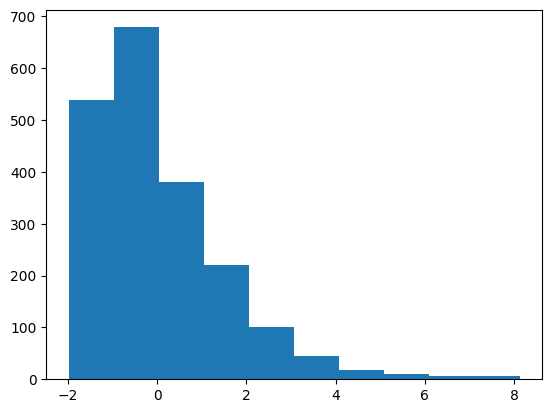

In [2]:
plt.hist(sigma.numpy())

In [3]:
torch.mean(sigma)

tensor(0.0351)

In [4]:
# Define the Quantile Regression Model
class QuantileRegressionModel(nn.Module):
    def __init__(self):
        super(QuantileRegressionModel, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the quantile loss function
def quantile_loss(pred, target, quantile, sigma=1.0):
    """
    Asymmetric Laplace log-likelihood loss for quantile regression (MLE view).
    
    Args:
        pred (Tensor): predicted quantile value
        target (Tensor): true target value
        quantile (float): quantile level τ (e.g., 0.05, 0.5, etc.)
        sigma (float): scale parameter of ALD (can also be learned)
    
    Returns:
        Tensor: average negative log-likelihood over the batch
    """
    error = target - pred
    pinball = torch.max((quantile - 1) * error, quantile * error)
    # nll = torch.log(torch.tensor(sigma)) - torch.log(torch.tensor(quantile * (1 - quantile))) + pinball / sigma
    # return torch.mean(nll)
    return pinball.mean()


In [5]:


# Add additional quantiles
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

# Initialize models for each quantile
models = {q: QuantileRegressionModel().to(device) for q in quantiles}
optimizers = {q: torch.optim.Adam(models[q].parameters(), lr=1e-3) for q in quantiles}

# Train each model
for quantile in (quantiles):
    model = models[quantile]
    optimizer = optimizers[quantile]
    model.train()
    for epoch in tqdm(range(500)):
        for x, y in DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True):
            pred = model(x)
            loss = quantile_loss(pred, y, quantile)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


100%|██████████| 500/500 [00:14<00:00, 33.92it/s]


In [6]:

# Make predictions for each quantile
predictions = {}
with torch.no_grad():
    for quantile in quantiles:
        predictions[quantile] = models[quantile](x_test.to(device)).squeeze()


# Extract predictions
lower_bound_95 = predictions[0.05].cpu()
lower_bound_75 = predictions[0.25].cpu()
median = predictions[0.5].cpu()
upper_bound_75 = predictions[0.75].cpu()
upper_bound_95 = predictions[0.95].cpu()


(-1.0, 4.0)

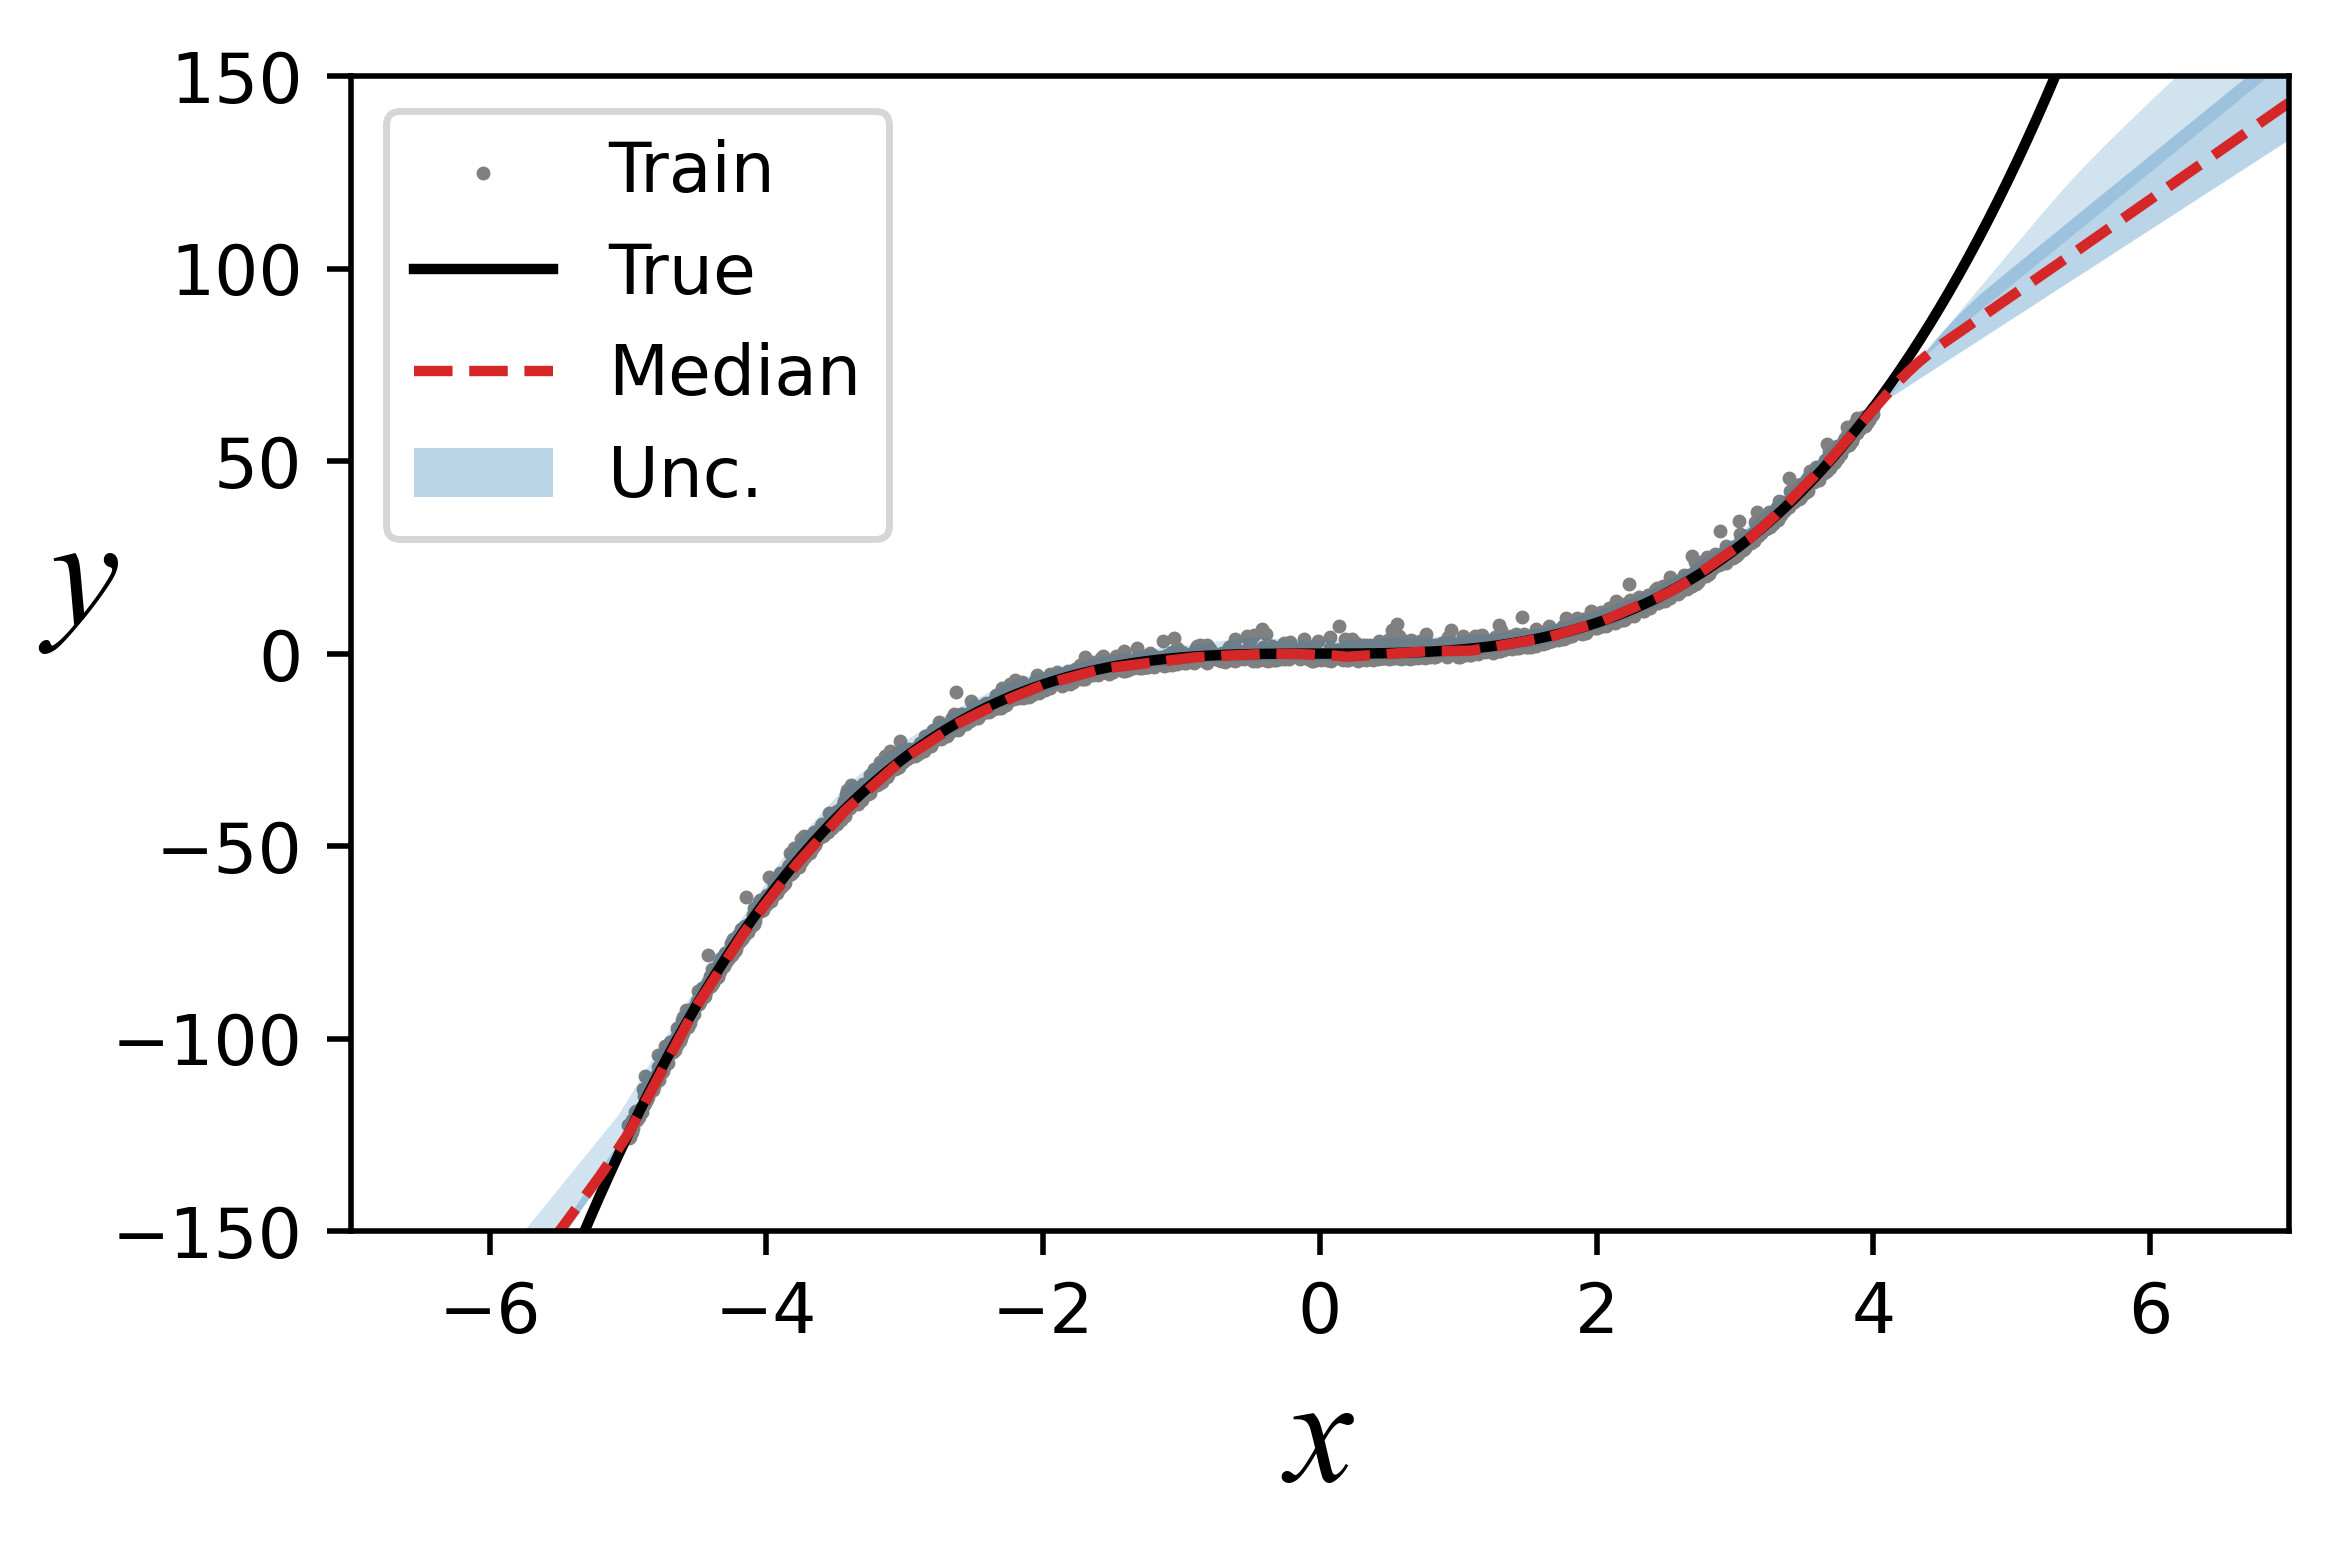

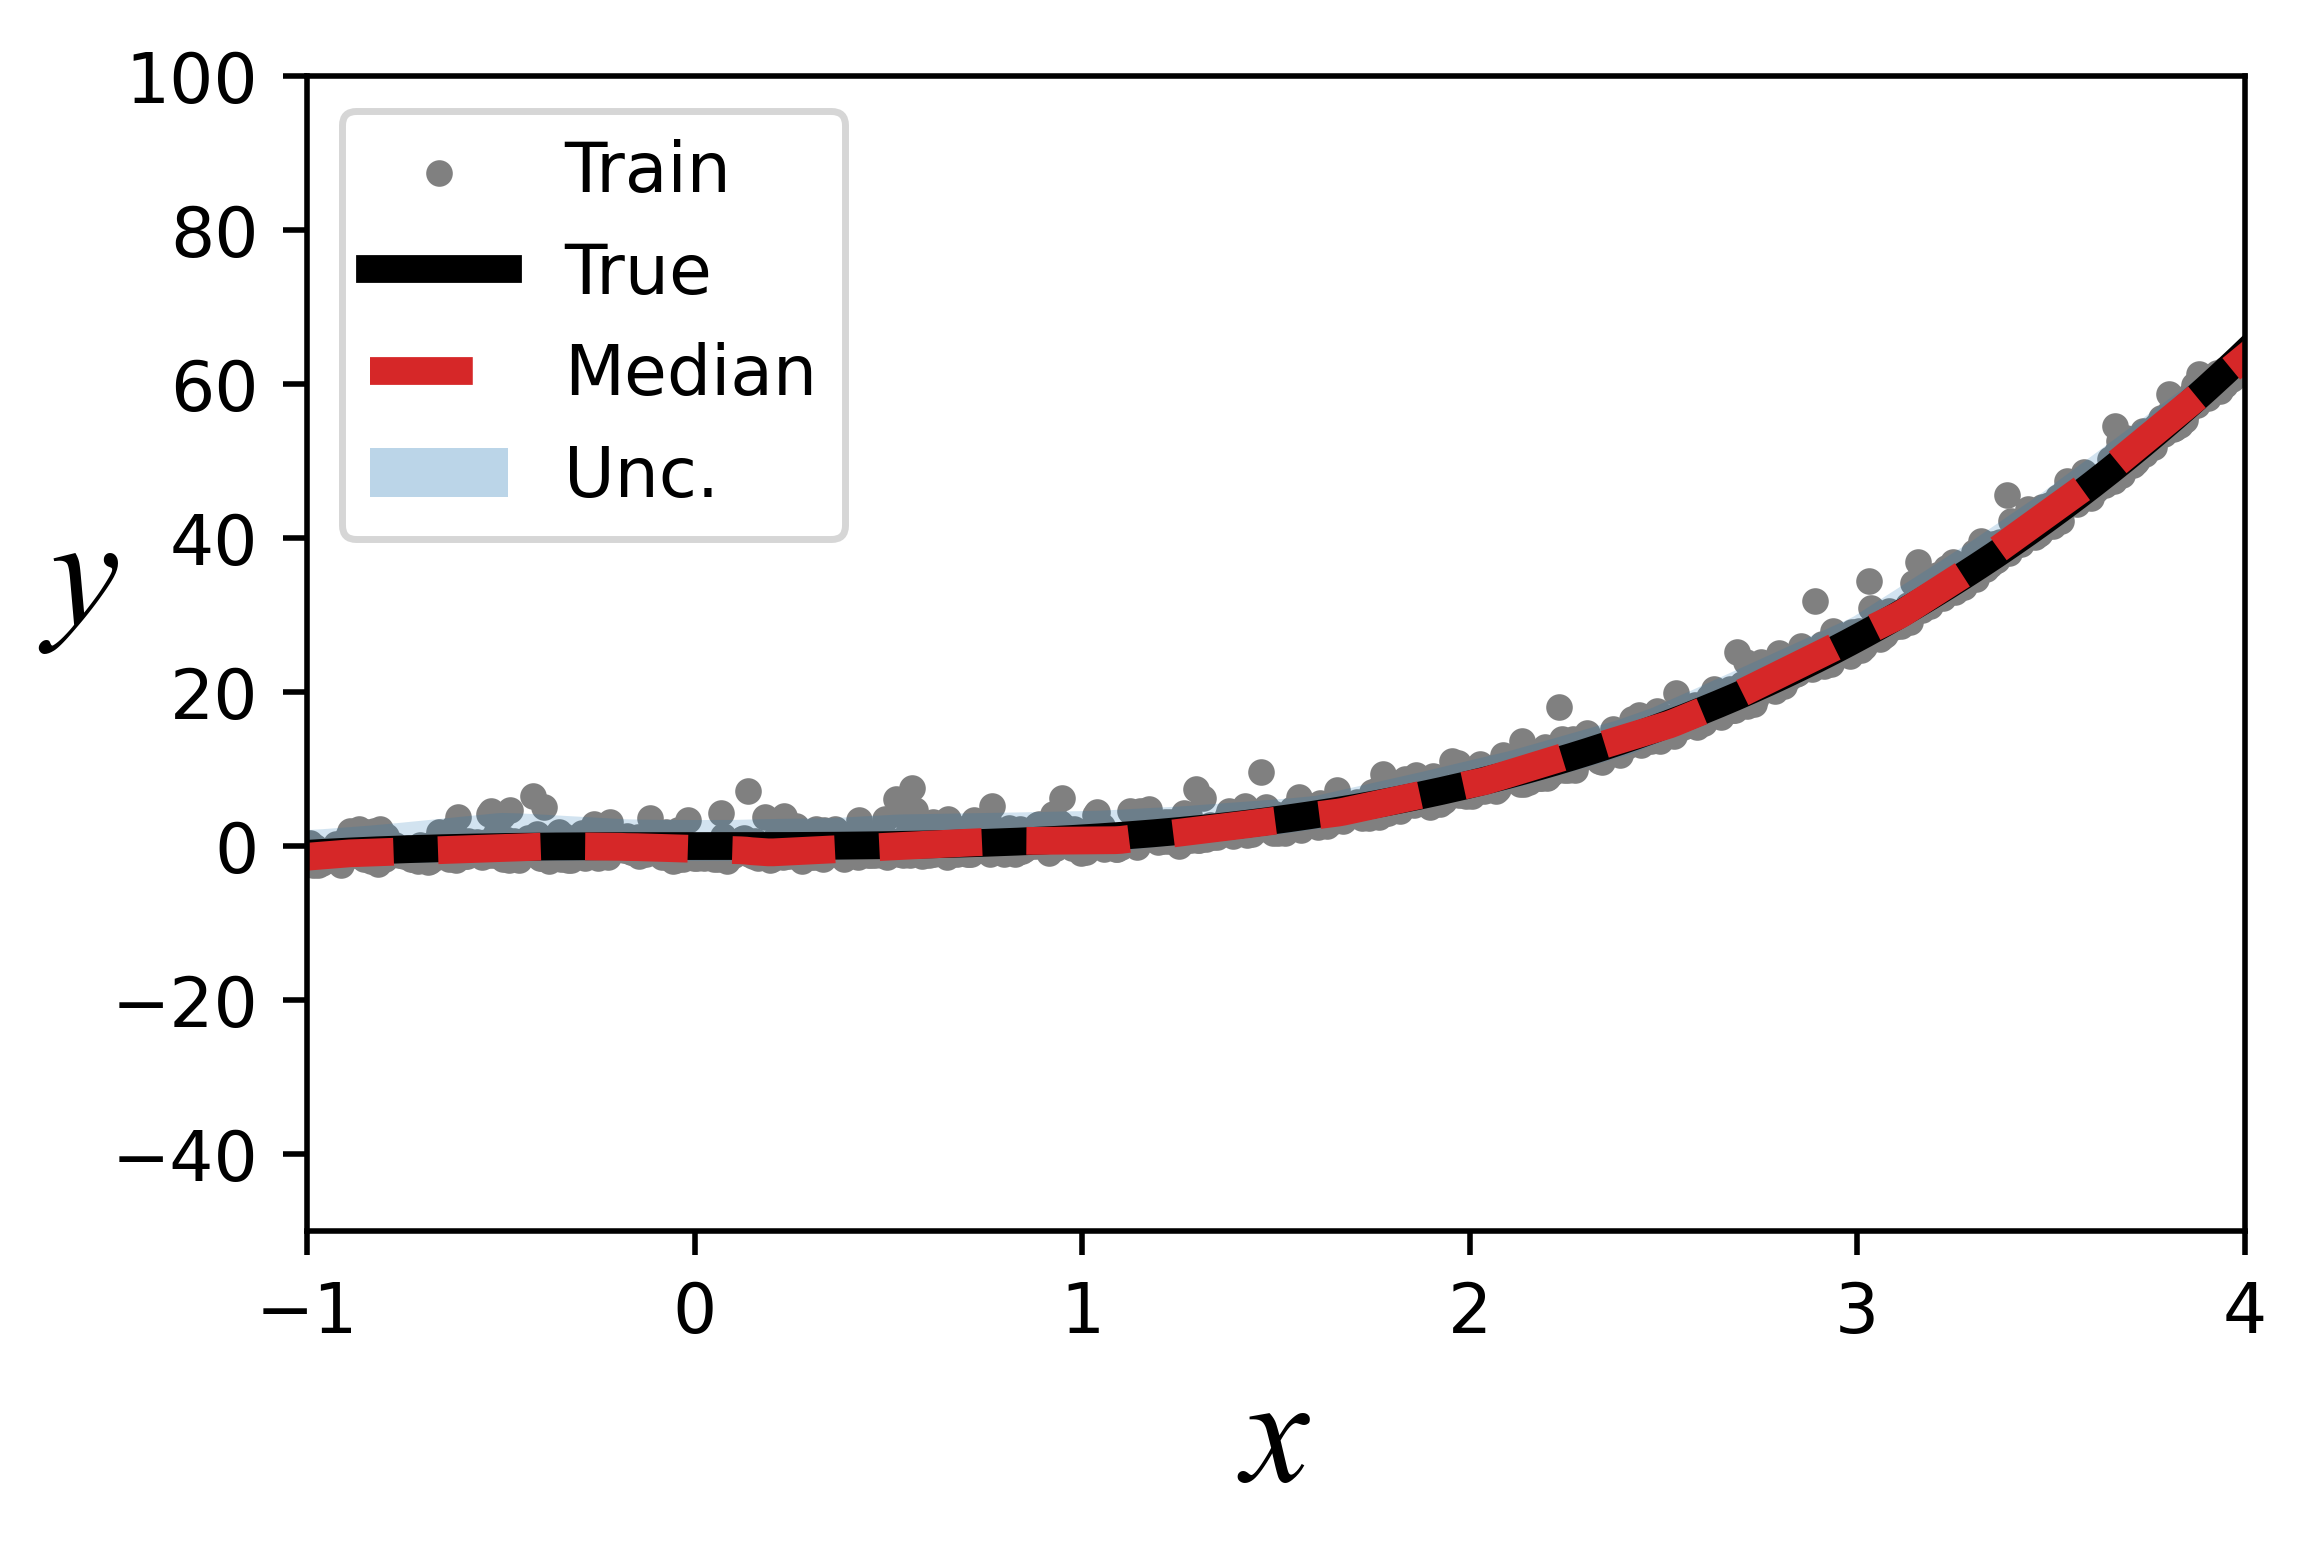

In [7]:

# Plot the results
plt.figure(figsize=(5, 3), dpi=500)
plt.scatter(x_train.cpu(), y_train.cpu(), s=1.0, c="gray", label="Train")
plt.plot(x_test.squeeze(), y_test.squeeze(), c="k", label="True")
plt.plot(x_test.squeeze(), median, c="tab:red", ls="--", label="Median")

# Fill between quantiles with different shades of blue
plt.fill_between(
    x_test.squeeze(),
    lower_bound_95,
    upper_bound_95,
    alpha=0.2,
    facecolor="tab:blue",
)
plt.fill_between(
    x_test.squeeze(),
    lower_bound_75,
    upper_bound_75,
    alpha=0.3,
    facecolor="tab:blue",
    label="Unc.",
)

plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-7, 7)

plt.xlabel("x", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
})

plt.ylabel("y", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
},rotation=0)
plt.legend(loc="upper left")


# ================================


# Plot the results
plt.figure(figsize=(5, 3), dpi=500)
plt.scatter(x_train.cpu(), y_train.cpu(), s=8.0, c="gray", label="Train", alpha=1, edgecolors=None)
plt.plot(x_test.squeeze(), y_test.squeeze(), c="k", label="True", linewidth=4)
plt.plot(x_test.squeeze(), median, c="tab:red", ls="--", label="Median", linewidth=4)

# Fill between quantiles with different shades of blue
plt.fill_between(
    x_test.squeeze(),
    lower_bound_95,
    upper_bound_95,
    alpha=0.2,
    facecolor="tab:blue",
)
plt.fill_between(
    x_test.squeeze(),
    lower_bound_75,
    upper_bound_75,
    alpha=0.3,
    facecolor="tab:blue",
    label="Unc.",
)

plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-7, 7)

plt.xlabel("x", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
})

plt.ylabel("y", fontsize=22, fontdict={
    'family': 'Times New Roman',
    'style': 'italic'
},rotation=0)
plt.legend(loc="upper left")
plt.gca().set_ylim(-50, 100)
plt.gca().set_xlim(-1, 4)


# Compute $\bar{s}$ using training set

In [8]:
def compute_gradient(models, x_test, y_test, quantiles):
    gradients = {}  # Store gradients for each quantile

    for quantile in quantiles:
        model = models[quantile]
        model.eval()
        model.zero_grad()

        x = x_test.to(device)
        y = y_test.to(device)

        pred = model(x).squeeze()
        loss = quantile_loss(pred, y, quantile)
        loss.backward()

        # Extract flattened gradient vector
        grad_vector = []
        for param in model.parameters():
            if param.grad is not None:
                grad_vector.append(param.grad.view(-1))
        gradients[quantile] = torch.cat(grad_vector).detach().cpu()

    return gradients


## Freeze all the parameters except for the last layer

In [9]:
for q in quantiles:
    for param in models[q].parameters():
        param.requires_grad = False
    for param in models[q].fc3.parameters():
        param.requires_grad = True

In [10]:
# Count trainable parameters
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_theta = count_trainable_params(models[0.5])*len(quantiles)  # Assuming all models have the same architecture
# Print result
print(f"Total trainable parameters: {n_theta}")

all_score = torch.zeros((n_theta,y_test_n.shape[0]))
for i in range(y_test_n.shape[0]):
    grads = compute_gradient(models, x_test[i], y_test_n[i], quantiles)
    score = torch.empty((1))
    for q in quantiles:
        #print(f"Gradient norm for quantile {q}: {grads[q].norm().item():.4f}")
        score = torch.cat((score, grads[q].squeeze(0)))
    all_score[:, i] = score[1:]  # Skip the first element which is empty

s_bar = all_score.mean(dim=1)

# Calculate inverse Sigma
Sigma_inv = torch.linalg.inv(torch.cov(all_score)+ 0.25 * torch.eye(n_theta))

Total trainable parameters: 325


In [11]:
cov_mat = torch.cov(all_score) + 0.25 * torch.eye(n_theta)
u, s, v = torch.linalg.svd(cov_mat)
cond_number = s.max() / s.min()
print("Condition number:", cond_number.item())

Condition number: 8075.708984375


In [12]:
def T_square(z,s_bar,Sigma_inv):
    return (z-s_bar).T @ Sigma_inv @ (z-s_bar)

## Test data without concept drift

In [13]:
x_no_drift = (torch.rand(100) * (4 - (-5)) + (-5)).unsqueeze(-1)
y_no_drift = x_no_drift**3 + torch.distributions.Gamma(concentration=2,rate=0.5).sample(x_no_drift.shape)*0.5 - 2

In [14]:
T2_all = []
z_0 = 0
lambda_0 = 0.1
for i in range(x_no_drift.shape[0]):
    s_each = compute_gradient(models, x_no_drift[i], y_no_drift[i], quantiles)
    s = torch.cat([s_each[q].squeeze(0) for q in quantiles])
    z_1 = lambda_0*s + (1-lambda_0)*z_0
    z_0 = z_1
    # Calculate T2 statistic
    T2 = T_square(z_1, s_bar, Sigma_inv).item()
    T2_all.append(T2)


/tmp/ipykernel_730023/2901480819.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  return (z-s_bar).T @ Sigma_inv @ (z-s_bar)


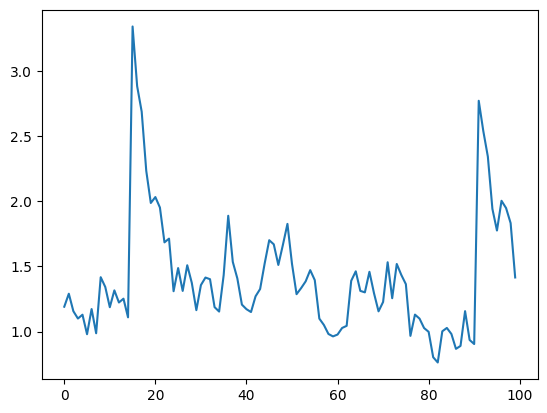

In [15]:
plt.plot(T2_all)

## Test data with concept drift

In [26]:
x_drift = (torch.rand(100) * (4 - (-5)) + (-5)).unsqueeze(-1)
y_drift = x_drift**3 + torch.distributions.Gamma(concentration=2,rate=0.5).sample(x_drift.shape)*0.5 - 2 - 1

In [27]:
T2_all_drift = []
z_0 = 0
lambda_0 = 0.1
for i in range(x_drift.shape[0]):
    s_each = compute_gradient(models, x_drift[i], y_drift[i], quantiles)
    s = torch.cat([s_each[q].squeeze(0) for q in quantiles])
    z_1 = lambda_0*s + (1-lambda_0)*z_0
    z_0 = z_1
    # Calculate T2 statistic
    T2 = T_square(z_1, s_bar, Sigma_inv).item()
    T2_all_drift.append(T2)


tensor(1.4164)
tensor(12.8881)


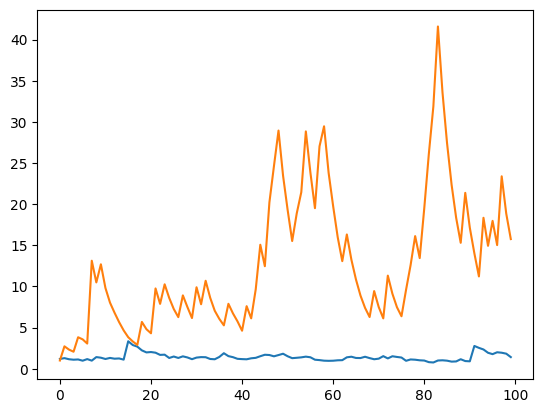

In [28]:
plt.plot(T2_all)
plt.plot(T2_all_drift)

print(torch.mean(torch.tensor(T2_all)))
print(torch.mean(torch.tensor(T2_all_drift)))

## Inject Drift during Test Time

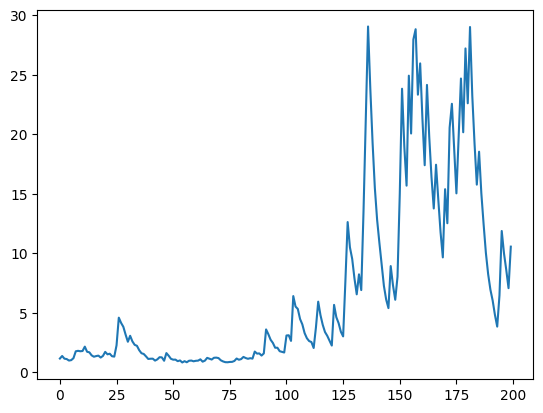

In [30]:
x_no_drift = (torch.rand(100) * (4 - (-5)) + (-5)).unsqueeze(-1)
y_no_drift = x_no_drift**3 + torch.distributions.Gamma(concentration=2,rate=0.5).sample(x_no_drift.shape)*0.5 - 2 
x_drift = (torch.rand(100) * (4 - (-5)) + (-5)).unsqueeze(-1)
y_drift = x_drift**3 + torch.distributions.Gamma(concentration=2,rate=0.5).sample(x_drift.shape)*0.5 - 2 - 1

x_stream = torch.cat((x_no_drift, x_drift), dim=0)
y_stream = torch.cat((y_no_drift, y_drift), dim=0)

T2_all_stream = []
z_0 = 0
lambda_0 = 0.1
for i in range(x_stream.shape[0]):
    s_each = compute_gradient(models, x_stream[i], y_stream[i], quantiles)
    s = torch.cat([s_each[q].squeeze(0) for q in quantiles])
    z_1 = lambda_0*s + (1-lambda_0)*z_0
    z_0 = z_1
    # Calculate T2 statistic
    T2 = T_square(z_1, s_bar, Sigma_inv).item()
    T2_all_stream.append(T2)
    
plt.plot(T2_all_stream)
